In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _schon import ContinuousSIS
import horgg
import argparse
import json
import pickle
import ray
from time import time
from format_data import format_data
from hgcm import *
from collections import deque

In [2]:
# Start Ray.
ray.shutdown()
ray.init(num_cpus=10)

2023-02-26 15:46:40,671	INFO worker.py:1553 -- Started a local Ray instance.


Python version:,3.10.6
Ray version:,2.3.0


## Preprocessing

### Load data

In [2]:
with open('./dat/coauth_subsample.json','r') as file:
    data = json.load(file)

In [3]:
#format data
edge_list = data['edge_list']
nmax = np.amax([len(g) for g in data['group_list']])

### Configuration

0.006402149102074656


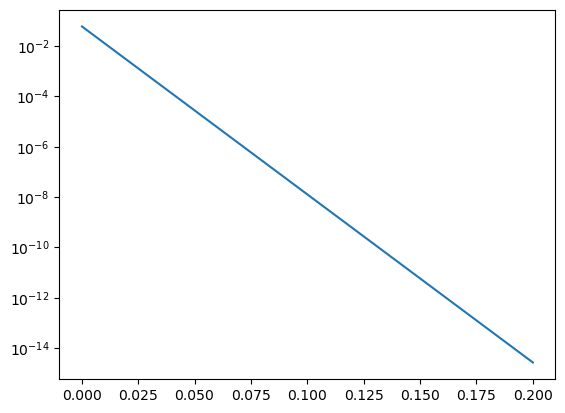

In [4]:
#rates
ymax = 500
rate = np.linspace(0.0001,0.2,ymax+1)
mu = 0.0065
nu = 1.

#rate distribution
dist = 'weibull'

py_n = weibull_rate_distribution(mu,nu,rate,ymax,nmax)
mean_rate = np.sum(py_n[:,0]*rate)
print(mean_rate)

plt.semilogy(rate,py_n[:,0])
plt.show()


#contagion
initial_infected_fraction = 10**(-4)

In [6]:
exp_id = 10

In [5]:
#get group list, i.e., list of nodes in the groups
groups = [[] for _ in range(len(data['group_list']))]
membership = [[] for _ in range(len(data['adj_dict']))]
for edge in edge_list:
    groups[edge[1]].append(edge[0])
    membership[edge[0]].append(edge[1])

In [6]:
len(membership)

116700

In [11]:
#structural properties
nlist = [len(group) for group in groups]
mlist = [len(memb) for memb in membership]
print(f"nmean: {np.mean(nlist)}, nstd: {np.std(nlist)}, nmax:{np.max(nlist)}")
print(f"mmean: {np.mean(mlist)}, nstd: {np.std(mlist)}, mmax:{np.max(mlist)}")

nmean: 3.8351382725482703, nstd: 1.728763788767425, nmax:25
mmean: 4.472947729220222, nstd: 21.001213413342175, mmax:1399


### Prepare group transmission rates

In [9]:
pdf = py_n[:,nmax]
cum = np.cumsum(pdf)
group_transmission_rate = []
for _ in range(len(data['group_list'])):
    r = np.random.random()
    ind = np.searchsorted(cum,r)
    group_transmission_rate.append(rate[ind])

In [10]:
print(np.mean(group_transmission_rate))

0.006399311518793901


### Prepare infection / recovery rate

In [11]:
recovery_rate = 1.
infection_rate = np.zeros((nmax+1,nmax+1))
for n in range(2,nmax+1):
    for i in range(nmax+1):
        infection_rate[n][i] = i

## Simulation

In [12]:
takeoff = False
while not takeoff:
    cont = ContinuousSIS(edge_list,recovery_rate,infection_rate,
                            group_transmission_rate)
    cont.measure_prevalence()
    cont.measure_time()
    cont.measure_infectious_set()

    cont.infect_fraction(initial_infected_fraction)

    #evolve and measure
    dt = 20
    dec_dt = 0.
    cont.evolve(dt,dec_dt,measure=True,quasistationary=False)
    
    #get the result measure
    for measure in cont.get_measure_vector():
        name = measure.get_name()
        if name == "time":
            time_list_ = list(measure.get_result()).copy()
        elif name == "infectious_set":
            infectious_set_list_ = list(measure.get_result()).copy()
        elif name == "prevalence":
            prevalence_list_ = list(measure.get_result()).copy()
    if prevalence_list_[-1] >= 3*10**(-3):
        takeoff = True

In [13]:
ind_up = np.argmin(np.abs(np.array(prevalence_list_)-0.001))
# ind_low = np.argmin(np.abs(np.array(prevalence_list_)-0.0002))
ind_low = 0

In [14]:
time_list = time_list_[ind_low:ind_up+1]
infectious_set_list = infectious_set_list_[ind_low:ind_up+1]
prevalence_list = prevalence_list_[ind_low:ind_up+1]
len(prevalence_list)

755

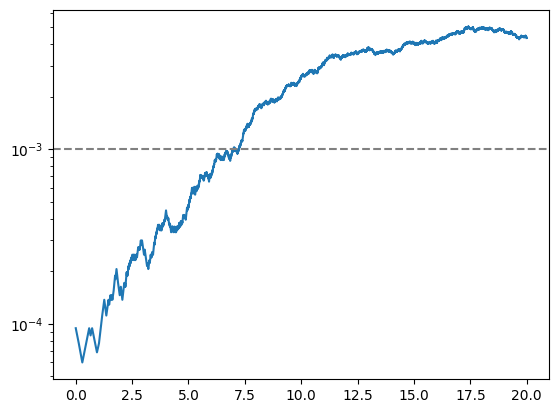

In [15]:
plt.semilogy(time_list_,prevalence_list_)
# plt.axhline(0.0002, ls='--', color='grey')
plt.axhline(0.001, ls='--', color='grey')

### Get events

In [16]:
event_list = []
for i in range(len(infectious_set_list)-1):
    if len(infectious_set_list[i+1]) > len(infectious_set_list[i]):
        #infection
        (node,) = infectious_set_list[i+1] - infectious_set_list[i] #tuple unpacking from a set
        infection_event = True
    else:
        (node,) = infectious_set_list[i] - infectious_set_list[i+1] #tuple unpacking from a set
        infection_event = False
    event_list.append((infection_event,node))

## Measure likelihood

In [17]:
def get_total_rate(infectious_set, groups, beta, nu):
    total_rate = len(infectious_set) #recovery events
    for group in groups:
        n = len(group)
        i = 0
        for node in group:
            if node in infectious_set:
                i+= 1
        total_rate += (n-i)*beta*i**nu
    return total_rate

def rates_infection_event(infectious_set,groups_sub,beta,nu):
    #infectious_set prior to event
    #groups_sub is a subset of groups where new infectious node belongs to
    #note: here nu is not the same nu as for the distribution, should probably change that
    rate_prior = 0
    rate_now = 0
    node_rate = 0
    for group in groups_sub:
        n = len(group)
        i = 0
        for node_ in group:
            if node_ in infectious_set:
                i += 1
        rate_prior += (n-i)*beta*i**nu
        rate_now += (n-(i+1))*beta*(i+1)**nu
        node_rate += beta*i**nu
    if node_rate == 0:
        raise RuntimeError("node_rate is 0")
    return node_rate,rate_prior,rate_now
    
def rates_recovery_event(infectious_set,groups_sub,beta,nu):
    #infectious_set prior to event
    #groups_sub is a subset of groups where new old node belongs to
    rate_prior = 0
    rate_now = 0
    for group in groups_sub:
        n = len(group)
        i = 0
        for node_ in group:
            if node_ in infectious_set:
                i += 1
        rate_prior += (n-i)*beta*i**nu
        rate_now += (n-(i-1))*beta*(i-1)**nu
    return rate_prior,rate_now   

def get_loglikelihood(time_list, infectious_set_list, event_list, groups, membership, beta, nu):        
    ll = 0
    total_rate = get_total_rate(infectious_set_list[0], groups, beta, nu)
    for i in range(len(time_list)-1):
        infectious_set = infectious_set_list[i].copy()
        dt = time_list[i+1]-time_list[i]
        event = event_list[i]
        infection_event,node = event[0],event[1]
        groups_sub = [groups[g] for g in membership[node]]
        node_rate = 0.
        if infection_event:
            assert node in infectious_set_list[i+1] - infectious_set_list[i]
            node_rate,rate_prior,rate_now = rates_infection_event(infectious_set,groups_sub,beta,nu)
        else:
            assert node in infectious_set_list[i] - infectious_set_list[i+1]
            rate_prior,rate_now = rates_recovery_event(infectious_set,groups_sub,beta,nu)
            node_rate = 1
        ll += -total_rate*dt + np.log(node_rate)
        #update total rate
        total_rate += (rate_now - rate_prior)
    return ll

In [18]:
beta_list = np.linspace(0.004,0.008,30)
nu_list = np.linspace(0.3,1.7,50)
Beta,Nu = np.meshgrid(beta_list,nu_list)

In [19]:
@ray.remote
def target(beta,nu):
    return get_loglikelihood(time_list, infectious_set_list, event_list, groups, membership, beta, nu)

In [20]:
# Start the tasks in parallel.
t1 = time()
result_ids = []
for beta,nu in zip(Beta.flatten(),Nu.flatten()):
    result_ids.append(target.remote(beta,nu))
results = ray.get(result_ids)
t2 = time()
print(f"It took {t2-t1} seconds")

It took 15.194658041000366 seconds


In [21]:
LL = np.array(results).reshape(Beta.shape)

In [22]:
LL -= np.amax(LL)
LH = np.exp(LL)

Text(0, 0.5, '$\\nu$')

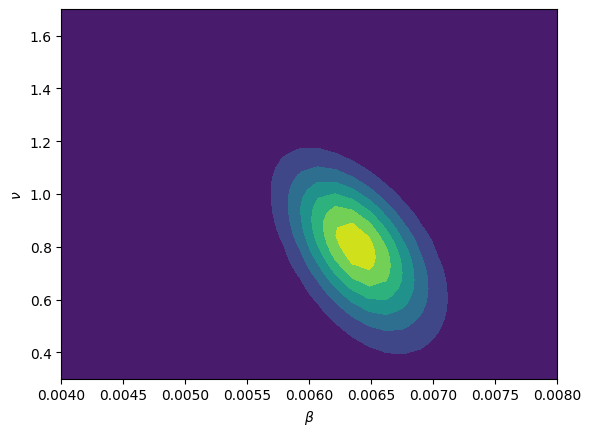

In [23]:
plt.contourf(Beta,Nu,LH)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\nu$')

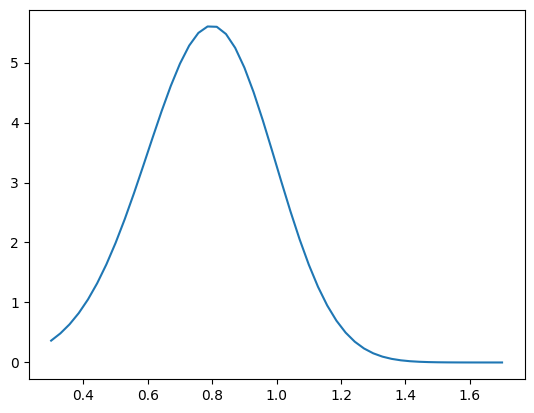

In [24]:
plt.plot(nu_list,np.sum(LH,axis=1))

## Save the results

In [25]:
data = {'beta':Beta.flatten(), 'nu':Nu.flatten(), 'll':LL.flatten()}
df = pd.DataFrame(data)
df['exp_id'] = exp_id
df.to_parquet(f'./dat/loglikelihood_real_net_v1_{exp_id}.pq')